# STATS 201 – Course Project

## Predicting Population Decline Using Migration and Demographic Data
GenAI tools were used as a learning source, ideation, improvement in code as well as to improve the visualization. If needed I will be able to explain all the code that is present there in this notebook.


## Imports and Environment Setup

In this section, we import the required Python libraries and configure basic display settings.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings for better readability
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

## Loading the Dataset

The dataset contains population and migration data for 186 countries over multiple decades.  
We load the CSV file and inspect its basic structure.

In [110]:
# Load dataset from local directory
df_raw = pd.read_csv("world_pop_mig_186_countries.csv")

# Inspect dataset shape and first few rows
df_raw.shape

(11904, 5)

## Data Cleaning and Structure

We standardize column names, identify key variables, and ensure the data are sorted correctly for time-series analysis.

In [111]:
# Standardize column names (This will help with the usage of the variable later, because we won't have variables with space " " for confusion)
# strip(): removes white space in the beginning and in the ending
df = df_raw.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Identify country and year columns
country_col = next((c for c in df.columns if "country" in c), None)
year_col = "year"

# Convert year to numeric and sort data
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")

# Remove the data that gets NaN after the conversion
df = df.dropna(subset=[year_col])
# Converts the numeric data to int again
df[year_col] = df[year_col].astype(int)
# Sort countries in alphabetical order and sort by year, ascending order is the default for both
df = df.sort_values([country_col, year_col]).reset_index(drop=True)

print(f"Cleaned dataset:")
print(f"Shape: {df.shape}")
print(f"Countries: {df[country_col].nunique()}")
print(f"Year range: {df[year_col].min()} to {df[year_col].max()}")
print(f"\nColumns: {df.columns.tolist()}")

Cleaned dataset:
Shape: (11904, 5)
Countries: 186
Year range: 1960 to 2023

Columns: ['country', 'year', 'population', 'netmigration', 'population_in_millions']


## Key Variables

We identify numeric variables related to population and migration that will later be used as predictors in the machine learning models.

In [112]:
# Identify columns that have numerical data
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()


# Identify population and migration-related variables
pop_candidates = [c for c in numeric_cols if "pop" in c]
mig_candidates = [c for c in numeric_cols if "migration" in c]

print(f"The columns with numerical data types: {numeric_cols}")
print(f"Population-related columns: {pop_candidates}")
print(f"Migration-related columns: {mig_candidates}")

The columns with numerical data types: ['year', 'population', 'netmigration', 'population_in_millions']
Population-related columns: ['population', 'population_in_millions']
Migration-related columns: ['netmigration']


## Derived Variables

We create simple derived variables such as population growth rate and lagged migration values to support exploratory analysis.

In [113]:
POP_COL = pop_candidates[0]
MIG_COL = mig_candidates[0]
# The above given variables store the column names, not the data
# Lagged population (Creates a column to record the population of the previous year)
# shift(1) helps to take data frfom one year ago
df["pop_lag1"] = df.groupby(country_col)[POP_COL].shift(1)

# Population growth rate (Creates a column to record population growth rate after calculation)
df["pop_growth_rate"] = (df[POP_COL] - df["pop_lag1"]) / df["pop_lag1"]

# Lagged migration (Creates a column to record the migration of the previous year)
df["mig_lag1"] = df.groupby(country_col)[MIG_COL].shift(1)

# Log population for scale normalization (Creates a column with natural log value of population)
df["log_pop"] = np.log(df[POP_COL].replace({0: np.nan}))

print("Derived variables created: ")
print(df[[country_col, year_col, POP_COL, MIG_COL, "pop_growth_rate"]].head())

Derived variables created: 
       country  year  population  netmigration  pop_growth_rate
0  Afghanistan  1960   8622466.0        2606.0              NaN
1  Afghanistan  1961   8790140.0        6109.0         0.019446
2  Afghanistan  1962   8969047.0        7016.0         0.020353
3  Afghanistan  1963   9157465.0        6681.0         0.021008
4  Afghanistan  1964   9355514.0        7079.0         0.021627


## Initial Exploratory Analysis

This section explores global trends in population growth and migration over time, as well as their relationship.

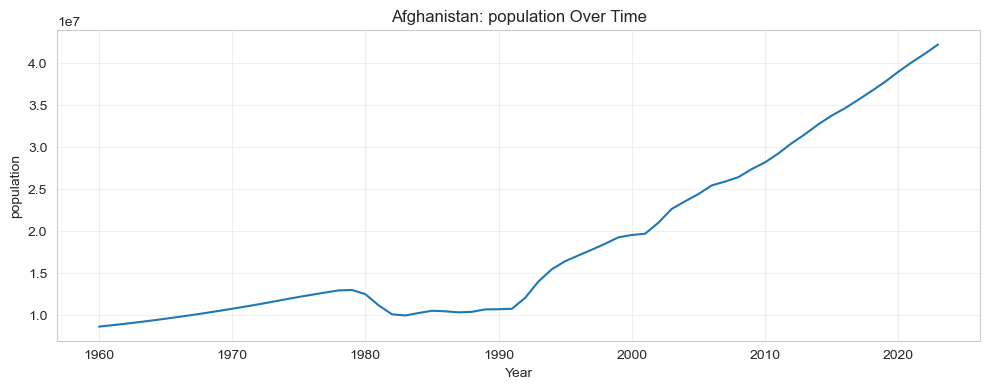

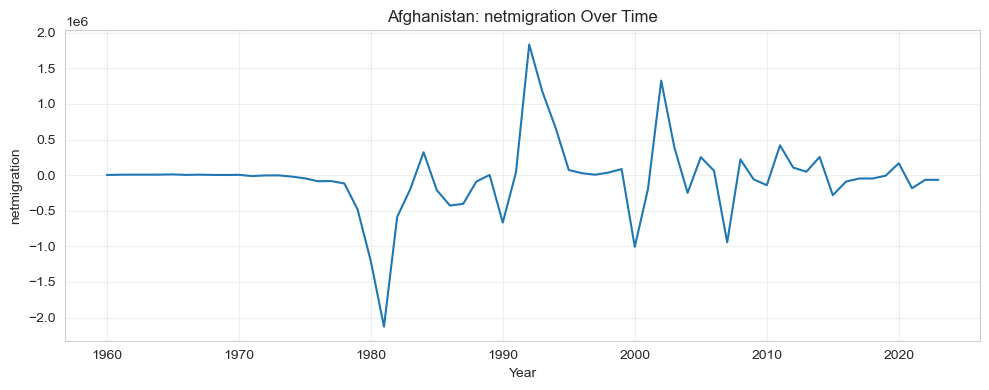

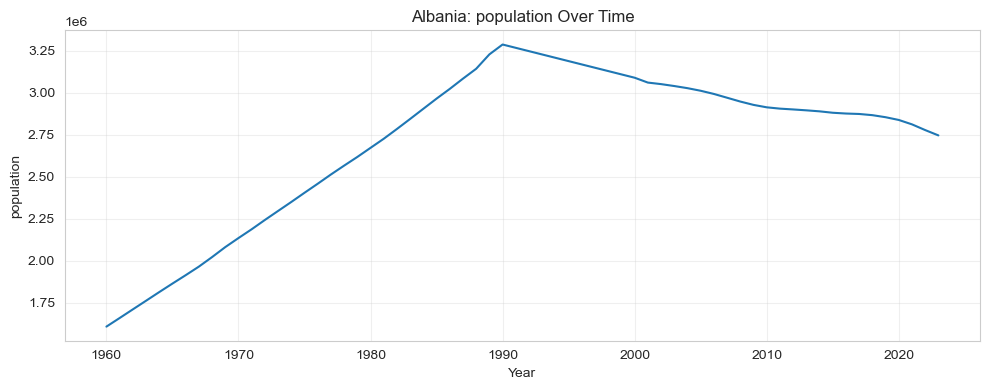

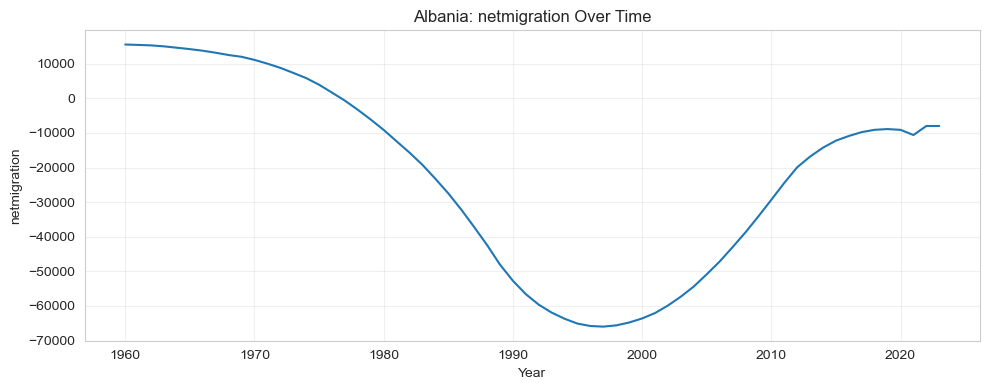

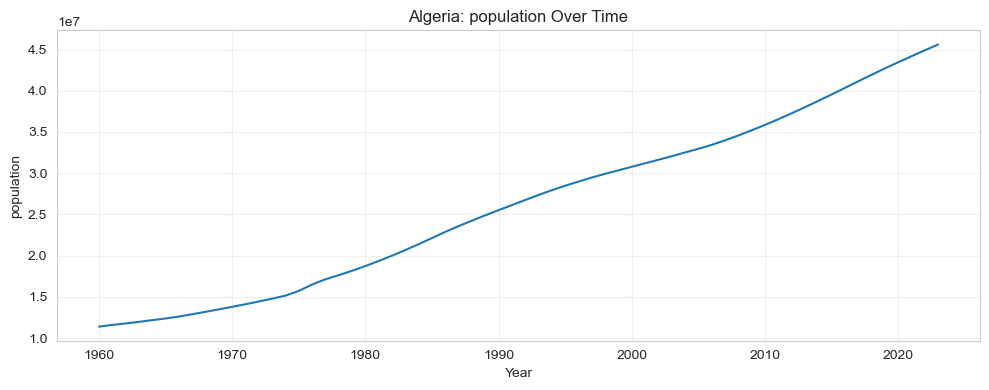

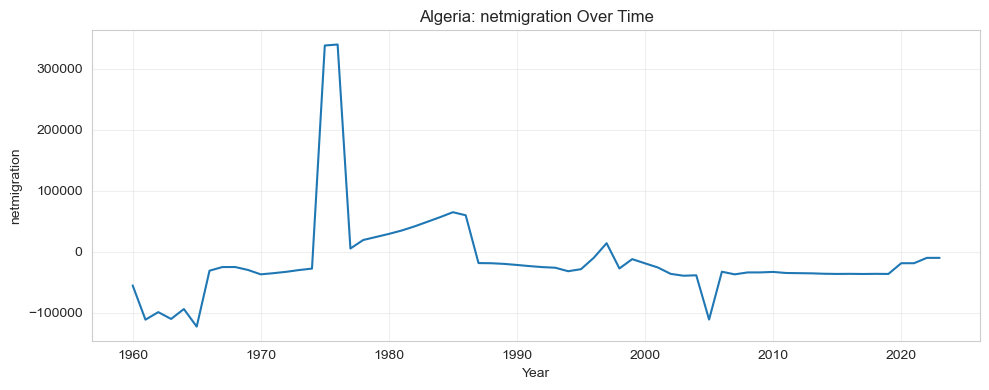

In [114]:
# Select a small subset of countries for visualization
# We use countries with the highest number of observations to ensure complete time series
top_countries = sorted(df[country_col].unique())[:3]

# Plot population and migration trends over time for selected countries
for c in top_countries:
    
    # Subset data for a single country, we don't need to sort here because we have sorted the same data twice before
    d = df[df[country_col] == c]
    
    # Plot population over time
    plt.figure(figsize=(10, 4))
    plt.plot(d[year_col], d[POP_COL])
    plt.title(f"{c}: {POP_COL} Over Time")
    plt.xlabel("Year")
    plt.ylabel(POP_COL)
    plt.grid(alpha=0.3)
    plt.tight_layout() # It automatically adjusts spacing between plot elements so that nothing overlaps or gets cut off
    plt.show()
    
    # Plot migration over time
    plt.figure(figsize=(10, 4))
    plt.plot(d[year_col], d[MIG_COL])
    plt.title(f"{c}: {MIG_COL} Over Time")
    plt.xlabel("Year")
    plt.ylabel(MIG_COL)
    plt.grid(alpha=0.3) # This is just for the opacity of the grid lines
    plt.tight_layout()
    plt.show()

## Standardize Column Names for Modeling

In [115]:
# Standardize column names to match what we'll use for modeling
df = df.rename(columns={
    country_col: 'Country Name',
    year_col: 'Year', 
    POP_COL: 'Population',
    MIG_COL: 'Net Migration',
    'pop_growth_rate': 'Population Growth' # pop_growth_rate is different because we already know the name of that column as 
    # it was the column generated by ourself
})

# Keep only essential columns and clean up
columns_to_keep = ['Country Name', 'Year', 'Population', 'Net Migration', 'Population Growth']
df = df[columns_to_keep].copy()

print("DATA PREPARATION FOR MODELING")
print(f"Dataset shape: {df.shape}")
print(f"Years: {df['Year'].min()} to {df['Year'].max()}")
print(f"Countries: {df['Country Name'].nunique()}") # nunique counts the number of unique values for the variable 'Country Name'
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

DATA PREPARATION FOR MODELING
Dataset shape: (11904, 5)
Years: 1960 to 2023
Countries: 186

Columns: ['Country Name', 'Year', 'Population', 'Net Migration', 'Population Growth']

First few rows:
  Country Name  Year  Population  Net Migration  Population Growth
0  Afghanistan  1960   8622466.0         2606.0                NaN
1  Afghanistan  1961   8790140.0         6109.0           0.019446
2  Afghanistan  1962   8969047.0         7016.0           0.020353
3  Afghanistan  1963   9157465.0         6681.0           0.021008
4  Afghanistan  1964   9355514.0         7079.0           0.021627


## Create Target Variable: Population Decline

We define our prediction task: **Can we predict if a country will experience population decline in the next N years?**

which helps us answer our research question:

**What demographic and migration indicators provide reliable early warning signals of population decline, and what does this reveal about the mechanisms driving demographic transitions?**

- **Prediction Window:** N = 5 years
- **Target Definition:** Binary (1 = decline occurs, 0 = no decline)
- **Decline Definition:** Population at any point in next 5 years drops below current year

In [116]:
# Set prediction window
PREDICTION_WINDOW = 5  # Predict decline in next 5 years

def create_decline_target(df, country_col='Country Name', year_col='Year', 
                         pop_col='Population', window=5):
    
    # Make a copy to avoid modifying original, because this df is the df only for this function
    df = df.copy()
    
    # Sort by country and year to ensure proper time ordering
    df = df.sort_values([country_col, year_col]).reset_index(drop=True)
    
    # Initialize target variable
    df['future_decline'] = 0
    
    print(f"Creating target variable with {window}-year prediction window...")
    
    # For each country, check if population declines in the next N years
    for country in df[country_col].unique():
        # Get data for this country only
        country_mask = df[country_col] == country # country_mask is a boolean filter like: True/False per row, it stores the value as True/False for all the countries in the iteration
        country_indices = df[country_mask].index # country_indices gives the actual row numbers for that country, here df[country_mask] only takes TRUE values
        # They are the index labels (row indices) of the current, processed dataframe inside the function
        # For each year in this country's data
        for idx in country_indices:
            current_year = df.loc[idx, year_col]

            # current_year = df.loc[idx, year_col], 
            # here current_year will be year_col value for idxth row(row given by the index number)
            
            current_pop = df.loc[idx, pop_col]
            
            # Skip if current population is missing
            if pd.isna(current_pop):
                continue
            
            # Look ahead N years (strict inequality: future_year > current_year), this is a panda boolean data type,
            # it checks true false for the conditions given below and assigns value of true or false for all eligible value of the dataframe
            # that is passed to it
            future_mask = (
                (df[country_col] == country) & 
                (df[year_col] > current_year) & 
                (df[year_col] <= current_year + window)
            )
            
            future_data = df[future_mask] # Only keeps future_mask with value as TRUE
            
            # Check if any future population is lower than current
            if len(future_data) > 0:
                min_future_pop = future_data[pop_col].min()
                
                # If future population drops below current, mark as decline
                if not pd.isna(min_future_pop) and min_future_pop < current_pop:
                    df.loc[idx, 'future_decline'] = 1
    
    return df

# Apply target variable creation, store the value of decline or non decline in the column that has the name 'future decline'
df = create_decline_target(
    df, 
    country_col='Country Name', 
    year_col='Year', 
    pop_col='Population',
    window=PREDICTION_WINDOW
)

# Check results
print("TARGET VARIABLE CREATED")
print(f"Total observations: {len(df)}")
print(f"Decline cases: {df['future_decline'].sum()} ({df['future_decline'].mean()*100:.2f}%)")
print(f"No decline cases: {(df['future_decline']==0).sum()} ({(df['future_decline']==0).mean()*100:.2f}%)")

# Show some examples
print(f"\nSample of data with target variable:")
print(df[['Country Name', 'Year', 'Population', 'future_decline']].head(20))

Creating target variable with 5-year prediction window...
TARGET VARIABLE CREATED
Total observations: 11904
Decline cases: 1388 (11.66%)
No decline cases: 10516 (88.34%)

Sample of data with target variable:
   Country Name  Year  Population  future_decline
0   Afghanistan  1960   8622466.0               0
1   Afghanistan  1961   8790140.0               0
2   Afghanistan  1962   8969047.0               0
3   Afghanistan  1963   9157465.0               0
4   Afghanistan  1964   9355514.0               0
5   Afghanistan  1965   9565147.0               0
6   Afghanistan  1966   9783147.0               0
7   Afghanistan  1967  10010030.0               0
8   Afghanistan  1968  10247780.0               0
9   Afghanistan  1969  10494489.0               0
10  Afghanistan  1970  10752971.0               0
11  Afghanistan  1971  11015857.0               0
12  Afghanistan  1972  11286753.0               0
13  Afghanistan  1973  11575305.0               0
14  Afghanistan  1974  11869879.0         

## Remove Incomplete Observations

In [117]:
# Calculate the last year we can make predictions for
MAX_YEAR = df['Year'].max()
LAST_PREDICTION_YEAR = MAX_YEAR - PREDICTION_WINDOW

print("REMOVING INCOMPLETE OBSERVATIONS")
print(f"Dataset spans: {df['Year'].min()} to {df['Year'].max()}")
print(f"Prediction window: {PREDICTION_WINDOW} years")
print(f"Last year we can predict for: {LAST_PREDICTION_YEAR}")
print(f"(We need data through {LAST_PREDICTION_YEAR + PREDICTION_WINDOW} to verify predictions)")

# Keep only observations where we can observe the full future window, which means it'll drop the data for the years 2019 - 2023
df_modeling = df[df['Year'] <= LAST_PREDICTION_YEAR].copy()

print(f"\nObservations before: {len(df)}")
print(f"Observations after: {len(df_modeling)}")
print(f"Observations dropped: {len(df) - len(df_modeling)}")
print(f"\nNew year range: {df_modeling['Year'].min()} to {df_modeling['Year'].max()}")

REMOVING INCOMPLETE OBSERVATIONS
Dataset spans: 1960 to 2023
Prediction window: 5 years
Last year we can predict for: 2018
(We need data through 2023 to verify predictions)

Observations before: 11904
Observations after: 10974
Observations dropped: 930

New year range: 1960 to 2018


## Train-Test Split

In [118]:
# Define split year
TRAIN_END_YEAR = 2010
TEST_START_YEAR = 2011

# Create train and test sets based on time
train_data = df_modeling[df_modeling['Year'] <= TRAIN_END_YEAR].copy()
test_data = df_modeling[df_modeling['Year'] >= TEST_START_YEAR].copy()

print("TEMPORAL TRAIN-TEST SPLIT")
print(f"\nTRAINING SET")
print(f"   Period: {train_data['Year'].min()} to {train_data['Year'].max()}")
print(f"   Observations: {len(train_data):,}")
print(f"   Countries: {train_data['Country Name'].nunique()}")
print(f"   Decline cases: {train_data['future_decline'].sum():,}")
print(f"   Decline rate: {train_data['future_decline'].mean()*100:.2f}%")


print(f"\nTEST SET")
print(f"   Period: {test_data['Year'].min()} to {test_data['Year'].max()}")
print(f"   Observations: {len(test_data):,}")
print(f"   Countries: {test_data['Country Name'].nunique()}")
print(f"   Decline cases: {test_data['future_decline'].sum():,}")
print(f"   Decline rate: {test_data['future_decline'].mean()*100:.2f}%")


# Verify no overlap
assert train_data['Year'].max() < test_data['Year'].min(), "ERROR: Train and test overlap!"
print("\nVerified: No temporal overlap between train and test sets")

TEMPORAL TRAIN-TEST SPLIT

TRAINING SET
   Period: 1960 to 2010
   Observations: 9,486
   Countries: 186
   Decline cases: 957
   Decline rate: 10.09%

TEST SET
   Period: 2011 to 2018
   Observations: 1,488
   Countries: 186
   Decline cases: 281
   Decline rate: 18.88%

Verified: No temporal overlap between train and test sets


## Time-Lagged Feature Engineering
In simple words, 

**Time-Lagged Feature Engineering means using what happened before to help predict what will happen next.**

OR

**It’s about turning raw data into useful signals for a model.**

This code creates time-lagged versions of important variables (population, migration, growth) so a model can learn from the past.

In simple terms:

It adds columns like
“population 1 year ago”,
“population 3 years ago”,
“population 5 years ago”
for every country. 

This will help us know the trend of population in short, medium and long time scale.

In [119]:
def create_lag_features(df, country_col='Country Name', lag_years=[1, 3, 5]):
    
    df = df.sort_values([country_col, 'Year']).copy() 
    
    # Columns to create lags for
    cols_to_lag = ['Population', 'Net Migration', 'Population Growth']
    
    print(f"Creating lag features for lags: {lag_years}")
    
    for lag in lag_years:
        for col in cols_to_lag:
            if col in df.columns: # This is to assure that the column to lag is actually there in the dataset
                # shift(lag) moves values DOWN by 'lag' rows within each country
                df[f'{col}_lag{lag}'] = df.groupby(country_col)[col].shift(lag) # shift will shift the columns as per the lag years 
                # giving it the value of year that it needs for that specific country
                
    return df

# Apply lag feature creation
print("FEATURE ENGINEERING: LAG FEATURES")
train_data = create_lag_features(train_data)
test_data = create_lag_features(test_data)

print("Lag features created!")
print(f"\nNew lag feature columns:")
lag_cols = [col for col in train_data.columns if 'lag' in col]
for col in lag_cols:
    print(f"  - {col}")

FEATURE ENGINEERING: LAG FEATURES
Creating lag features for lags: [1, 3, 5]
Creating lag features for lags: [1, 3, 5]
Lag features created!

New lag feature columns:
  - Population_lag1
  - Net Migration_lag1
  - Population Growth_lag1
  - Population_lag3
  - Net Migration_lag3
  - Population Growth_lag3
  - Population_lag5
  - Net Migration_lag5
  - Population Growth_lag5


## Chage Feature Function

This part is about reducing the columns into the columns that will actually be useful to train the models.

**The model will only be trained on the changed feature function**

In [120]:
def create_change_features(df, country_col='Country Name'):
    
    df = df.sort_values([country_col, 'Year']).copy() # This is not really needed because we have done it multiple times before
    # but this is a good practice
    
    # Year-over-year changes (absolute and percentage)
    for col in ['Population', 'Net Migration']:
        if col in df.columns:
            # Change from previous year
            df[f'{col}_change'] = df.groupby(country_col)[col].diff()
            # diff() find the difference between the current value and the previous value, it can be negative as well as positive
            
            # change ratio compared to previous year
            df[f'{col}_pct_change'] = df.groupby(country_col)[col].pct_change()
            # pct_change() does this (current_value − previous_value) / previous_value, it can also be negative as well as positive
    
    # Rolling statistics (5-year moving average)
    # moving average helps to smoothen the data rather than confusing the model on each and every spike in every small difference
    for col in ['Population', 'Population Growth']:
        if col in df.columns:
            df[f'{col}_ma5'] = (
                df.groupby(country_col)[col]
                .rolling(window=5, min_periods=3)
                .mean()
                .reset_index(level=0, drop=True)
                # .reset_index(level=0, drop=True) is required because groupby().rolling() creates a MultiIndex of Level 0: country name and 
                # Level 1: the original df.index values i.e. 0, 1, 2, 3, ..., 
                # and resetting the group level ensures the result aligns correctly with the original dataframe.
            )
    
    return df

print("FEATURE ENGINEERING: CHANGE FEATURES")
# Feature engineering is the process of transforming raw data into relevant information for use by machine learning models. 
# In other words, feature engineering is the process of creating predictive model features.
train_data = create_change_features(train_data)
test_data = create_change_features(test_data)

print("Change features created!")
print(f"\nNew change feature columns:")
change_cols = [col for col in train_data.columns if any(x in col for x in ['change', 'ma5'])]
for col in change_cols:
    print(f"  - {col}")

FEATURE ENGINEERING: CHANGE FEATURES
Change features created!

New change feature columns:
  - Population_change
  - Population_pct_change
  - Net Migration_change
  - Net Migration_pct_change
  - Population_ma5
  - Population Growth_ma5


## Domain-Specific Features

Domain-specific features are features engineered using knowledge of how population and migration behave in the real world, rather than purely statistical transformations.

In [121]:
def create_domain_features(df, country_col='Country Name'):
    
    df = df.copy()
    
    # Migration as percentage of population (migration intensity)
    if 'Net Migration' in df.columns and 'Population' in df.columns:
        df['migration_intensity'] = df['Net Migration'] / df['Population']
    
    # Decade indicators (for capturing era-specific effects)
    df['decade'] = (df['Year'] // 10) * 10
    
    # Years since data start (time trend)
    df['years_since_start'] = df['Year'] - df['Year'].min()
    
    return df

print("FEATURE ENGINEERING: DOMAIN FEATURES")
train_data = create_domain_features(train_data)
test_data = create_domain_features(test_data)
# Domain feature rely on knowledge about population dynamics, not just statistics
print("Domain features created!")
print(f"\nTotal columns now: {len(train_data.columns)}")
print(f"\nAll features created:")
feature_cols = [col for col in train_data.columns if col not in ['Country Name', 'Year', 'future_decline']]
# We have not here because these won't be used as features to train the model, and the ones that get printed below will be the ones
# that will be used to train the models
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

FEATURE ENGINEERING: DOMAIN FEATURES
Domain features created!

Total columns now: 24

All features created:
   1. Population
   2. Net Migration
   3. Population Growth
   4. Population_lag1
   5. Net Migration_lag1
   6. Population Growth_lag1
   7. Population_lag3
   8. Net Migration_lag3
   9. Population Growth_lag3
  10. Population_lag5
  11. Net Migration_lag5
  12. Population Growth_lag5
  13. Population_change
  14. Population_pct_change
  15. Net Migration_change
  16. Net Migration_pct_change
  17. Population_ma5
  18. Population Growth_ma5
  19. migration_intensity
  20. decade
  21. years_since_start


## Missing Data Analysis

In [122]:
from sklearn.impute import SimpleImputer

# Analyze missing data in training set
print("MISSING DATA ANALYSIS (Training Set)")

missing_train = train_data.isnull().sum() # This gives the sum of missing data in each column
missing_train_pct = (train_data.isnull().sum() / len(train_data)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_train,
    'Missing_Percent': missing_train_pct
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values(
    'Missing_Percent', ascending=False
)

if len(missing_summary) > 0:
    print("\nColumns with missing values:")
    print(missing_summary)
else:
    print("\nNo missing values found!")

MISSING DATA ANALYSIS (Training Set)

Columns with missing values:
                          Missing_Count  Missing_Percent
Population Growth_lag5             1116        11.764706
Population_lag5                     930         9.803922
Net Migration_lag5                  930         9.803922
Population Growth_lag3              744         7.843137
Population_lag3                     558         5.882353
Net Migration_lag3                  558         5.882353
Population Growth_ma5               558         5.882353
Population Growth_lag1              372         3.921569
Population_ma5                      372         3.921569
Net Migration_pct_change            272         2.867384
Population Growth                   186         1.960784
Population_lag1                     186         1.960784
Net Migration_lag1                  186         1.960784
Population_change                   186         1.960784
Population_pct_change               186         1.960784
Net Migration_change 

## Impute Missing Data

This is the process of filling out reasonable substitute value for the missing data. This will ensure that we utilize the data rather than directly dropping it.

In [123]:
# Identify numeric columns for imputation
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()

# Remove target variable and identifier columns from imputation
cols_to_exclude = ['future_decline', 'Year', 'decade', 'years_since_start']
numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]

print(f"Numeric columns to impute: {len(numeric_cols)}")

# Check for problematic columns (all NaN or all infinite)
problematic_cols = []
for col in numeric_cols:
    # Check if column is all NaN
    if train_data[col].isna().all():
        problematic_cols.append(col)
        print(f"Warning: Column '{col}' is entirely NaN - will be removed")
        continue
    
    # Check for infinite values
    if np.isinf(train_data[col]).any():
        print(f"Warning: Column '{col}' contains infinite values - replacing with NaN")
        train_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        # inplace means modify the column directly and no need to make a copy
        test_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove problematic columns
numeric_cols = [col for col in numeric_cols if col not in problematic_cols]

print(f"\nColumns after cleaning: {len(numeric_cols)}")

# Check if we have valid columns to impute
if len(numeric_cols) == 0:
    print("No valid numeric columns to impute!")
else:
    # Fit imputer on training data ONLY, and impute the median of that column for the missing values.
    imputer = SimpleImputer(strategy='median')
    
    # Fit on training data; calculates the median for all the column of the train data, and stores it inside imputer
    # only train data is used so that there is no bias created by the test data
    imputer.fit(train_data[numeric_cols])
    
    # Transform both train and test using the fitted imputer
    train_data[numeric_cols] = imputer.transform(train_data[numeric_cols])
    test_data[numeric_cols] = imputer.transform(test_data[numeric_cols])
    
    print("\n  Missing data imputed using median strategy")
    print(f"  Remaining missing values in train: {train_data[numeric_cols].isnull().sum().sum()}") # first sums add for inside each 
    # columns and second sum adds the values of those columns
    print(f"  Remaining missing values in test: {test_data[numeric_cols].isnull().sum().sum()}")

Numeric columns to impute: 19

Columns after cleaning: 19

  Missing data imputed using median strategy
  Remaining missing values in train: 0
  Remaining missing values in test: 0


/var/folders/mg/bhg2988s5fq125xdwn5j_0nh0000gn/T/ipykernel_53851/3451578241.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/mg/bhg2988s5fq125xdwn5j_0nh0000gn/T/ipykernel_53851/3451578241.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

## Class Balance Visualization

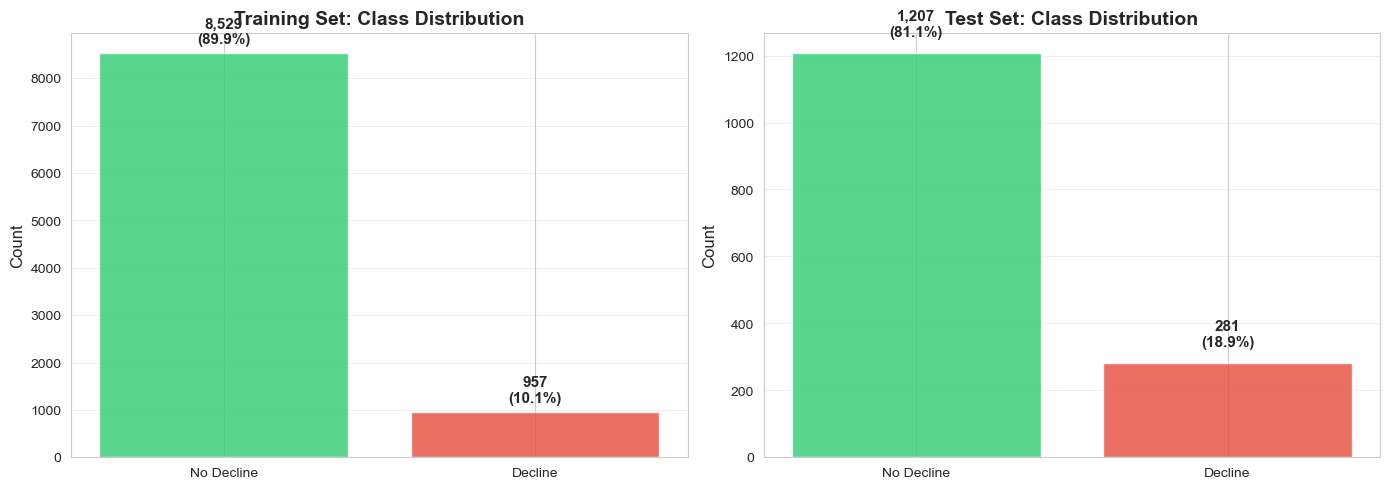

Class balance indicates IMBALANCED dataset - we may need to address this in modeling!


In [124]:
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 5) # setting the parameters

# 1. Class Balance Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = train_data['future_decline'].value_counts().sort_index()
# counts the value for both true and false and then arranges in the order of 0, 1
axes[0].bar(['No Decline', 'Decline'], train_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8) # this alpha is for the bar
axes[0].set_title('Training Set: Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].text(0, train_counts[0] + 200, f'{train_counts[0]:,}\n({train_counts[0]/len(train_data)*100:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
# position of the label = 0 chart, 200 above the height of the bar; has data represented by commas; text is centred above the bar
axes[0].text(1, train_counts[1] + 200, f'{train_counts[1]:,}\n({train_counts[1]/len(train_data)*100:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Test set distribution
test_counts = test_data['future_decline'].value_counts().sort_index()
axes[1].bar(['No Decline', 'Decline'], test_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8)
axes[1].set_title('Test Set: Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].text(0, test_counts[0] + 50, f'{test_counts[0]:,}\n({test_counts[0]/len(test_data)*100:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
axes[1].text(1, test_counts[1] + 50, f'{test_counts[1]:,}\n({test_counts[1]/len(test_data)*100:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Class balance indicates", end=" ")
if train_counts[1]/len(train_data) < 0.3:
    print("IMBALANCED dataset - we may need to address this in modeling!")
else:
    print("relatively balanced dataset.")

## Temporal Trends Visualization

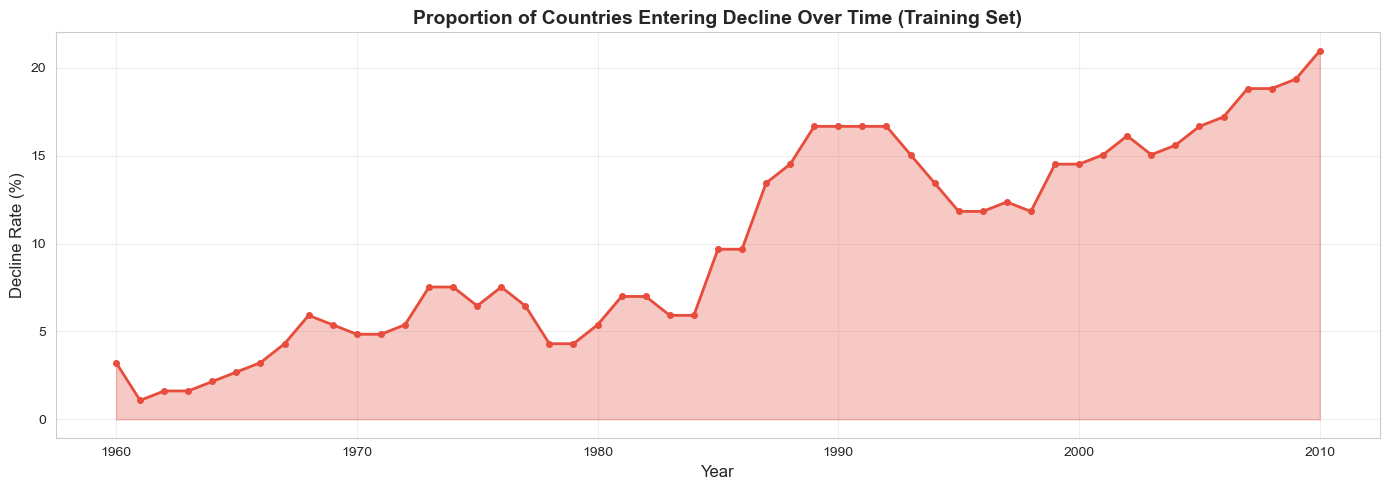

Decline rate ranges from 1.1% to 21.0%


In [125]:
# Temporal Trends in Decline Rate
decline_by_year = train_data.groupby('Year')['future_decline'].agg(['mean', 'count'])
# Look for column year and look for the corresponding value present in 'future_decline'; calculates the mean 
# that helps to get percentage easily and then counts the number of countries having data for that year

plt.figure(figsize=(14, 5))
plt.plot(decline_by_year.index, decline_by_year['mean'] * 100, 
         marker='o', linewidth=2, markersize=4, color='#e74c3c')
# decline_by_year.index contains the year values used for grouping and serves as the x-axis when plotting temporal trends.
plt.fill_between(decline_by_year.index, 0, decline_by_year['mean'] * 100, alpha=0.3, color='#e74c3c')
# fills the graph from the x-axis to the line
plt.title('Proportion of Countries Entering Decline Over Time (Training Set)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Decline Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3) # enables grid lines and says how opaque should it be
plt.tight_layout()
plt.show()

print(f"Decline rate ranges from {decline_by_year['mean'].min()*100:.1f}% to {decline_by_year['mean'].max()*100:.1f}%")

## Feature Distributions by Target

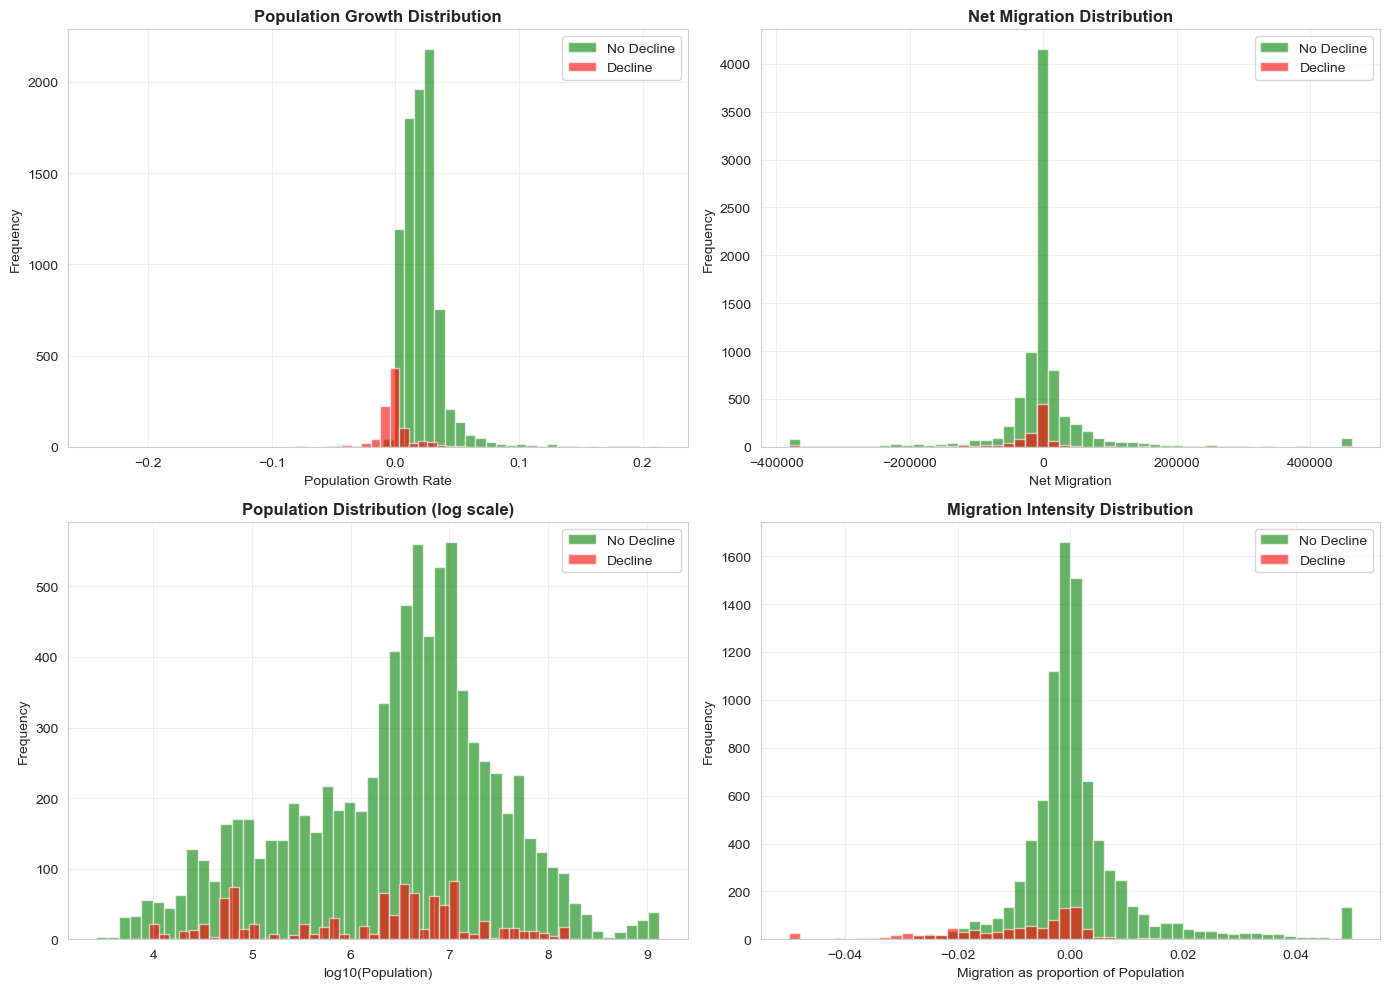

In [126]:
# Feature Distributions by Target Class
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Population Growth by target
if 'Population Growth' in train_data.columns:
    axes[0, 0].hist(train_data[train_data['future_decline']==0]['Population Growth'].dropna(), 
                    bins=50, alpha=0.6, label='No Decline', color='green')
    # bins will split the data range into 50 intervals
    axes[0, 0].hist(train_data[train_data['future_decline']==1]['Population Growth'].dropna(), 
                    bins=50, alpha=0.6, label='Decline', color='red')
    axes[0, 0].set_title('Population Growth Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Population Growth Rate')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

# Net Migration by target
if 'Net Migration' in train_data.columns:
    # Clip extreme values for better visualization
    mig_clip = train_data['Net Migration'].clip(
        train_data['Net Migration'].quantile(0.01),
        train_data['Net Migration'].quantile(0.99)
    )
    # Any value below the 1st percentile is replaced by the 1st-percentile value,
    # any value above the 99th percentile is replaced by the 99th-percentile value.

    axes[0, 1].hist(mig_clip[train_data['future_decline']==0].dropna(), 
                    bins=50, alpha=0.6, label='No Decline', color='green')
    axes[0, 1].hist(mig_clip[train_data['future_decline']==1].dropna(), 
                    bins=50, alpha=0.6, label='Decline', color='red')
    axes[0, 1].set_title('Net Migration Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Net Migration')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

# Population (log scale) by target
if 'Population' in train_data.columns:
    axes[1, 0].hist(np.log10(train_data[train_data['future_decline']==0]['Population'].dropna() + 1), 
                    bins=50, alpha=0.6, label='No Decline', color='green')
    # It has +1 before taking the log to avoid taking log of value zero.
    axes[1, 0].hist(np.log10(train_data[train_data['future_decline']==1]['Population'].dropna() + 1), 
                    bins=50, alpha=0.6, label='Decline', color='red')
    axes[1, 0].set_title('Population Distribution (log scale)', fontweight='bold')
    axes[1, 0].set_xlabel('log10(Population)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

# Migration intensity by target
if 'migration_intensity' in train_data.columns:
    # Filter extreme outliers for visualization
    mi_clean = train_data['migration_intensity'].clip(-0.05, 0.05)
    axes[1, 1].hist(mi_clean[train_data['future_decline']==0].dropna(), 
                    bins=50, alpha=0.6, label='No Decline', color='green')
    axes[1, 1].hist(mi_clean[train_data['future_decline']==1].dropna(), 
                    bins=50, alpha=0.6, label='Decline', color='red')
    axes[1, 1].set_title('Migration Intensity Distribution', fontweight='bold')
    axes[1, 1].set_xlabel('Migration as proportion of Population')
    axes[1, 1].set_ylabel('Frequency') # frequency here means country-year (possible combinations of country and year)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# The frequency in the diagram represents country-year combination

## Import ML Libraries

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

## Prepare Feature Matrix

A feature matrix is the table of input values that a machine-learning model uses to learn patterns and make predictions.

In [128]:
# Select features for modeling
# Start with original features and some engineered features
feature_cols = [
    # Original features
    'Population', 'Net Migration', 'Population Growth',
    
    # Lag features
    'Population_lag1', 'Population_lag3', 'Population_lag5',
    'Net Migration_lag1', 'Net Migration_lag3',
    'Population Growth_lag1', 'Population Growth_lag3',
    
    # Change features
    'Population_change', 'Population_pct_change',
    'Net Migration_change', 'Net Migration_pct_change',
    
    # Rolling features
    'Population_ma5', 'Population Growth_ma5',
    
    # Domain features
    'migration_intensity', 'years_since_start'
]

# Keep only features that exist in our dataframe
feature_cols = [col for col in feature_cols if col in train_data.columns]

# Create feature matrices
X_train = train_data[feature_cols].copy()
y_train = train_data['future_decline'].copy()

X_test = test_data[feature_cols].copy()
y_test = test_data['future_decline'].copy()

print("FEATURE MATRIX PREPARED")
print(f"Number of features: {len(feature_cols)}")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"\nFeatures selected:")
for i, feat in enumerate(feature_cols, 1): # Here enumerate helps to keep track of the value of i as the iteration goes on 
    # which in return helps to give the numbers in front of the features
    print(f"  {i:2d}. {feat}")
    # 2d gives minimum width of the character, without it, the 1-digit number would be oriented towards the left instead of right

FEATURE MATRIX PREPARED
Number of features: 18
Training samples: 9,486
Test samples: 1,488

Features selected:
   1. Population
   2. Net Migration
   3. Population Growth
   4. Population_lag1
   5. Population_lag3
   6. Population_lag5
   7. Net Migration_lag1
   8. Net Migration_lag3
   9. Population Growth_lag1
  10. Population Growth_lag3
  11. Population_change
  12. Population_pct_change
  13. Net Migration_change
  14. Net Migration_pct_change
  15. Population_ma5
  16. Population Growth_ma5
  17. migration_intensity
  18. years_since_start


## Dummy Classifier

The very first model, this gives the values of bare minimum for the parameters to check

In [129]:
# Train dummy classifier (predicts majority class)
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train)

# Predictions
y_pred_dummy = dummy_model.predict(X_test)

# Evaluation
print("BASELINE MODEL 1: DUMMY CLASSIFIER (MAJORITY CLASS)")
print(f"Strategy: Always predict the most frequent class")

# Metrics
acc_dummy = accuracy_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy, zero_division=0)
# If a metric would require division by zero, return 0 instead of throwing an error or warning
recall_dummy = recall_score(y_test, y_pred_dummy, zero_division=0)
f1_dummy = f1_score(y_test, y_pred_dummy, zero_division=0)

print(f"\nPerformance Metrics:")
print(f"   Accuracy:  {acc_dummy:.4f}")
print(f"   Precision: {precision_dummy:.4f}")
print(f"   Recall:    {recall_dummy:.4f}")
print(f"   F1-Score:  {f1_dummy:.4f}")

# Confusion matrix
cm_dummy = confusion_matrix(y_test, y_pred_dummy)
print(f"\nConfusion Matrix:")
print(f"   [[TN={cm_dummy[0,0]}, FP={cm_dummy[0,1]}]")
print(f"    [FN={cm_dummy[1,0]}, TP={cm_dummy[1,1]}]]")

print("\nThis is our minimum baseline - any real model must beat this!")

BASELINE MODEL 1: DUMMY CLASSIFIER (MAJORITY CLASS)
Strategy: Always predict the most frequent class

Performance Metrics:
   Accuracy:  0.8112
   Precision: 0.0000
   Recall:    0.0000
   F1-Score:  0.0000

Confusion Matrix:
   [[TN=1207, FP=0]
    [FN=281, TP=0]]

This is our minimum baseline - any real model must beat this!


## Logistic Regression

In [130]:
# Train logistic regression with default parameters
print("Training Logistic Regression...")
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg_model.predict(X_test)
y_pred_proba_logreg = logreg_model.predict_proba(X_test)[:, 1]  # Probability of class 1
# Suppose for one country-year:
# Model output: 0.85
# This means:
# “Given the features, the model believes there is an 85% chance this observation belongs to class 1.”
# And this value is given by y_pred_logreg

# Evaluation
print("BASELINE MODEL 2: LOGISTIC REGRESSION")

# Metrics
acc_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg, zero_division=0)
recall_logreg = recall_score(y_test, y_pred_logreg, zero_division=0)
f1_logreg = f1_score(y_test, y_pred_logreg, zero_division=0)
auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

print(f"\nPerformance Metrics:")
print(f"   Accuracy:  {acc_logreg:.4f}")
print(f"   Precision: {precision_logreg:.4f}")
print(f"   Recall:    {recall_logreg:.4f}")
print(f"   F1-Score:  {f1_logreg:.4f}")
print(f"   ROC-AUC:   {auc_logreg:.4f}")

# Confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print(f"\nConfusion Matrix:")
print(f"   [[TN={cm_logreg[0,0]}, FP={cm_logreg[0,1]}]")
print(f"    [FN={cm_logreg[1,0]}, TP={cm_logreg[1,1]}]]")

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': logreg_model.coef_[0]
})
feature_importance_lr['Abs_Coefficient'] = np.abs(feature_importance_lr['Coefficient'])
feature_importance_lr = feature_importance_lr.sort_values('Abs_Coefficient', ascending=False)
# Gives absolute value to the coefficient and arranges it in descending order

print(f"\nTop 10 Most Important Features (by absolute coefficient):")
print(feature_importance_lr.head(10)[['Feature', 'Coefficient']].to_string(index=False))

Training Logistic Regression...
BASELINE MODEL 2: LOGISTIC REGRESSION

Performance Metrics:
   Accuracy:  0.8542
   Precision: 0.6260
   Recall:    0.5658
   F1-Score:  0.5944
   ROC-AUC:   0.8416

Confusion Matrix:
   [[TN=1112, FP=95]
    [FN=122, TP=159]]

Top 10 Most Important Features (by absolute coefficient):
                 Feature   Coefficient
       Population_change -4.598913e-05
      Net Migration_lag1  1.225323e-05
    Net Migration_change -7.336476e-06
           Net Migration -3.990551e-06
       years_since_start -3.902921e-06
      Net Migration_lag3 -2.086979e-06
          Population_ma5  8.326575e-07
         Population_lag1 -4.713459e-07
Net Migration_pct_change -3.622644e-07
         Population_lag5 -3.356409e-07


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Decision Tree

In [131]:
# Train decision tree with limited depth
print("Training Decision Tree...")
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Predictions
y_pred_tree = tree_model.predict(X_test)
y_pred_proba_tree = tree_model.predict_proba(X_test)[:, 1]
# Suppose for one country-year:
# Decision Tree output: 0.72
# This means:
# “Given the feature values, the decision tree sends this observation to a leaf
#  where 72% of the training samples had future_decline = 1.”
# So the tree estimates a 72% chance that this country-year will enter population decline.
# This value comes from:
# y_pred_proba_tree


# Evaluation
print("BASELINE MODEL 3: DECISION TREE (max_depth=5)")

# Metrics
acc_tree = accuracy_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree, zero_division=0)
recall_tree = recall_score(y_test, y_pred_tree, zero_division=0)
f1_tree = f1_score(y_test, y_pred_tree, zero_division=0)
auc_tree = roc_auc_score(y_test, y_pred_proba_tree)

print(f"\nPerformance Metrics:")
print(f"   Accuracy:  {acc_tree:.4f}")
print(f"   Precision: {precision_tree:.4f}")
print(f"   Recall:    {recall_tree:.4f}")
print(f"   F1-Score:  {f1_tree:.4f}")
print(f"   ROC-AUC:   {auc_tree:.4f}")

# Confusion matrix
cm_tree = confusion_matrix(y_test, y_pred_tree)
print(f"\nConfusion Matrix:")
print(f"   [[TN={cm_tree[0,0]}, FP={cm_tree[0,1]}]")
print(f"    [FN={cm_tree[1,0]}, TP={cm_tree[1,1]}]]")

# Feature importance
feature_importance_tree = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': tree_model.feature_importances_
})
feature_importance_tree = feature_importance_tree.sort_values('Importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance_tree.head(10).to_string(index=False))

Training Decision Tree...
BASELINE MODEL 3: DECISION TREE (max_depth=5)

Performance Metrics:
   Accuracy:  0.9227
   Precision: 0.8807
   Recall:    0.6833
   F1-Score:  0.7695
   ROC-AUC:   0.9345

Confusion Matrix:
   [[TN=1181, FP=26]
    [FN=89, TP=192]]

Top 10 Most Important Features:
                 Feature  Importance
   Population_pct_change    0.838363
       Population Growth    0.041852
     migration_intensity    0.033209
  Population Growth_lag1    0.017765
Net Migration_pct_change    0.016462
         Population_lag5    0.014796
           Net Migration    0.010888
      Net Migration_lag1    0.009889
       years_since_start    0.006221
              Population    0.004973



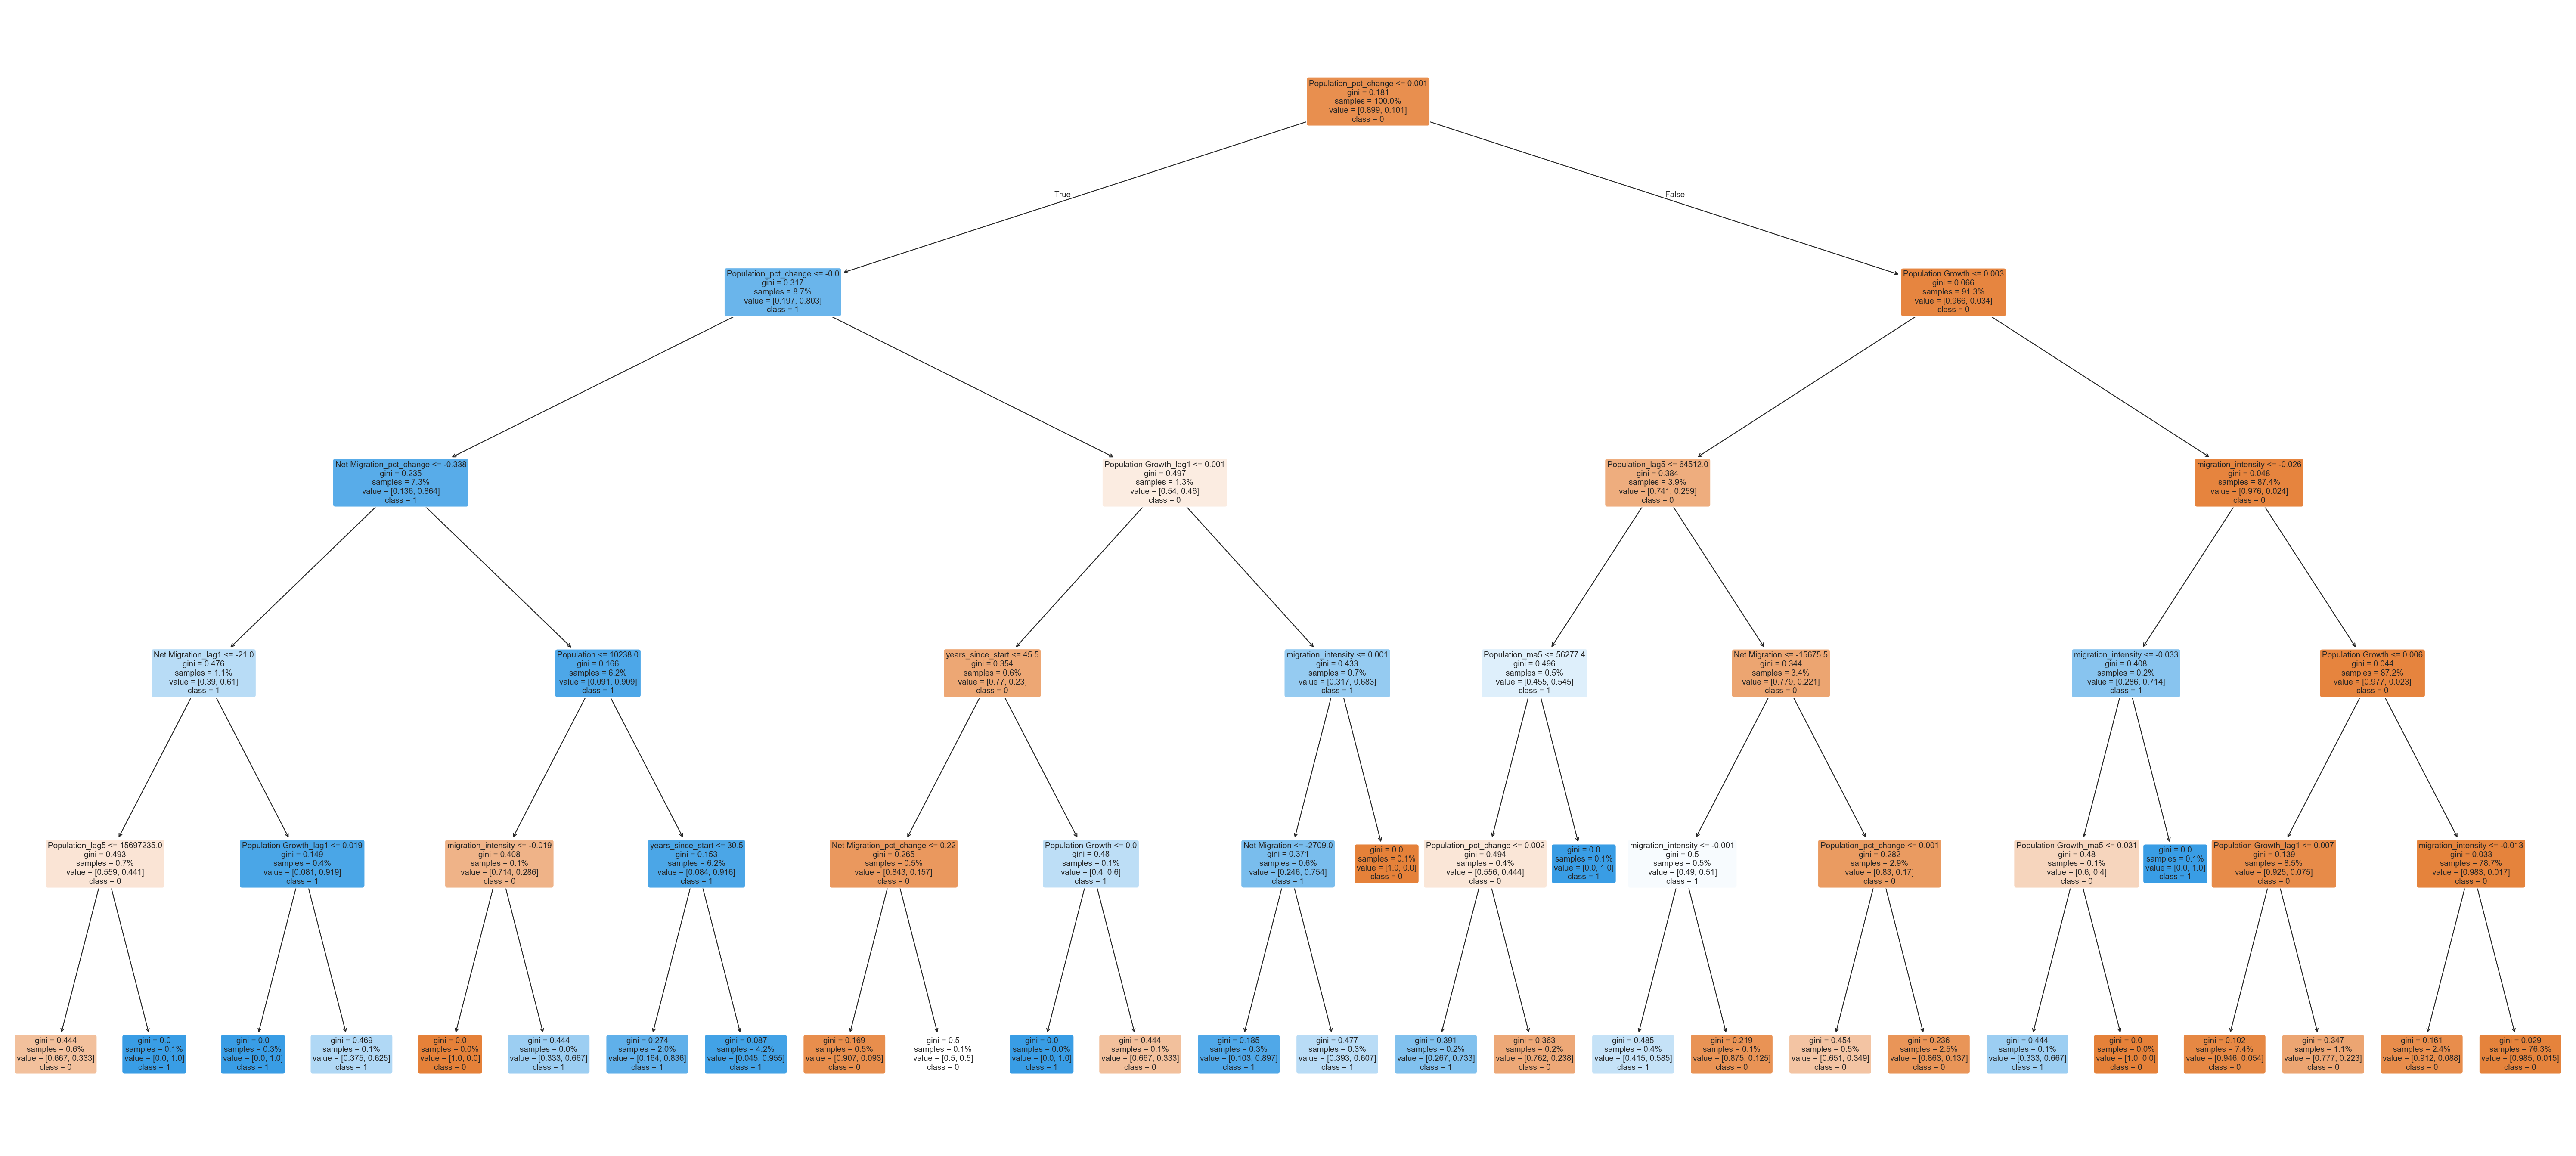

In [141]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from IPython.display import display, HTML

# Create large figure (same scale as before)
fig = plt.figure(figsize=(40, 18), dpi=150)

plot_tree(
    tree_model,
    feature_names=feature_cols,
    class_names=[str(c) for c in tree_model.classes_],
    filled=True,
    rounded=True,
    impurity=True,
    proportion=True,
    fontsize=9
)

plt.tight_layout()

# Save figure to buffer
buf = BytesIO()
fig.savefig(buf, format="png", bbox_inches="tight")
plt.close(fig)
buf.seek(0)

# Encode image to base64
img_b64 = base64.b64encode(buf.read()).decode("utf-8")

# Display in scrollable container
display(HTML(f"""
<div style="
  width: 250%;
  max-height: 650px;
  overflow: auto;
  border: 1.5px solid #aaa;
  border-radius: 10px;
  padding: 10px;
  background: #fff;">
  <img src="data:image/png;base64,{img_b64}" style="width: max-content; height: auto;" />
</div>
"""))


In [133]:
# Export the png image
from PIL import Image
from io import BytesIO
import base64

# Decode the base64 image back to bytes
img_bytes = base64.b64decode(img_b64)

# Load as image and save
img = Image.open(BytesIO(img_bytes))
img.save("decision_tree.png")

print("Saved as decision_tree.png")


Saved as decision_tree.png


## Create Comparison DataFrame

In [134]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Dummy (Majority)', 'Logistic Regression', 'Decision Tree'],
    'Accuracy': [acc_dummy, acc_logreg, acc_tree],
    'Precision': [precision_dummy, precision_logreg, precision_tree],
    'Recall': [recall_dummy, recall_logreg, recall_tree],
    'F1-Score': [f1_dummy, f1_logreg, f1_tree],
    'ROC-AUC': [0.5, auc_logreg, auc_tree]  # Dummy has no meaningful ROC-AUC
})

print("BASELINE MODEL COMPARISON")
print(results_df.to_string(index=False))


BASELINE MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
   Dummy (Majority)  0.811156   0.000000 0.000000  0.000000 0.500000
Logistic Regression  0.854167   0.625984 0.565836  0.594393 0.841616
      Decision Tree  0.922715   0.880734 0.683274  0.769539 0.934479


## Visualize Model Comparison

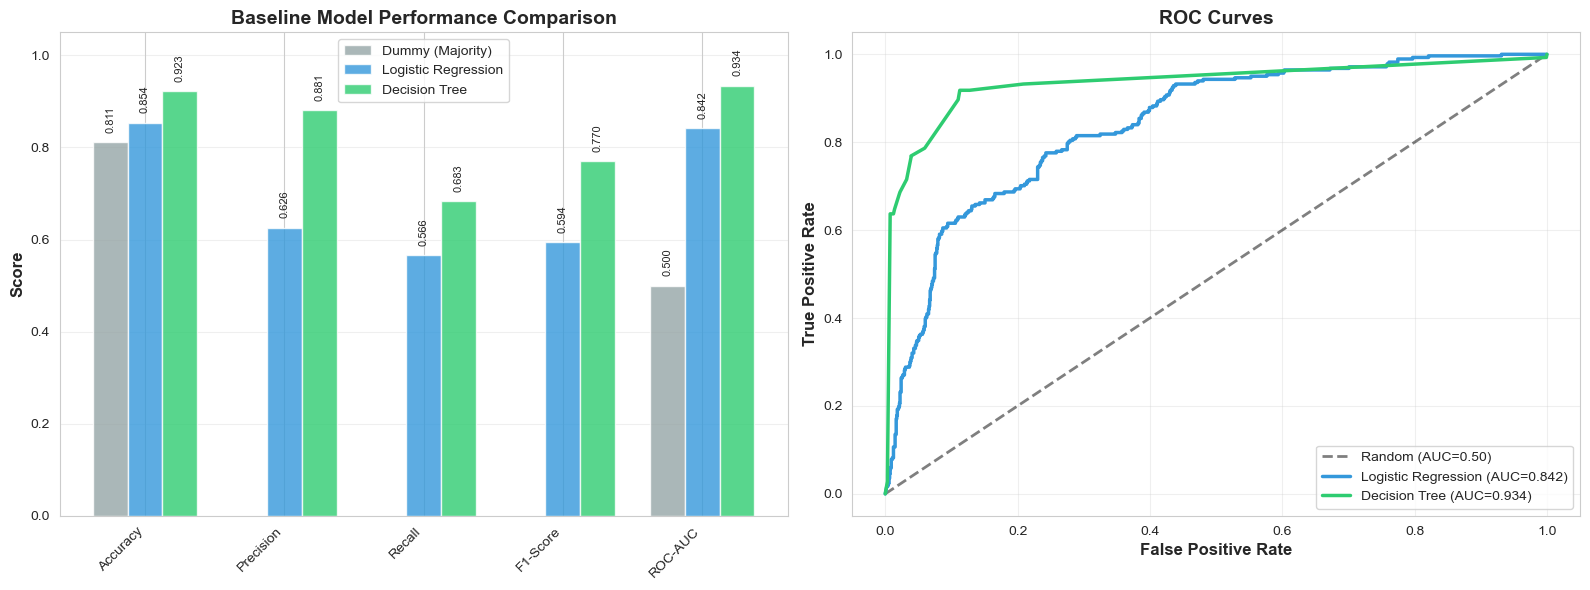

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_to_plot)) # It gives position for our metrics in the graph
width = 0.25 # width of each individual bar

colors = ['#95a5a6', '#3498db', '#2ecc71']
for i, model in enumerate(results_df['Model']):
    values = results_df.iloc[i][metrics_to_plot].values
    axes[0].bar(x + i*width, values, width, label=model, color=colors[i], alpha=0.8)
    # Makes bars for 1 model for all 5 metrics and then goes to make for another model

axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Baseline Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width)
# It tells Matplotlib where to place the x-axis tick marks (and labels) so they appear centered under each group of bars.
# A tick mark is the small line on an axis that marks a specific value and serves as the anchor for axis labels like “Accuracy” or “Recall”.
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3) # We write y here because y represents the value
axes[0].set_ylim([0, 1.05])
# sets the vertical (y-axis) range of the plot.

# Add value labels on bars
for i, model in enumerate(results_df['Model']): 
    values = results_df.iloc[i][metrics_to_plot].values # iloc starts indexing from 1
    for j, v in enumerate(values):
        if v > 0:  # Only label non-zero values
            axes[0].text(x[j] + i*width, v + 0.02, f'{v:.3f}', 
            # x[j] tells which metrics it is v + 0.02 places it just above the max height
                        ha='center', va='bottom', fontsize=8, rotation=90)
            # va='bottom' means “place the text so its bottom edge sits at this y-value,” which is ideal for labels above bars.

# 2. ROC Curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)
# fpr = false positive rate, tpr = true positive rate
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_proba_tree)
# _ is used to capture the third return value (thresholds) from roc_curve() while explicitly signaling that it’s intentionally ignored.

axes[1].plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.50)', linewidth=2, alpha=0.5) # k-- = black dashed line
axes[1].plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC={auc_logreg:.3f})', 
            linewidth=2.5, color='#3498db')
axes[1].plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC={auc_tree:.3f})', 
            linewidth=2.5, color='#2ecc71')
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion Matrix Visualization

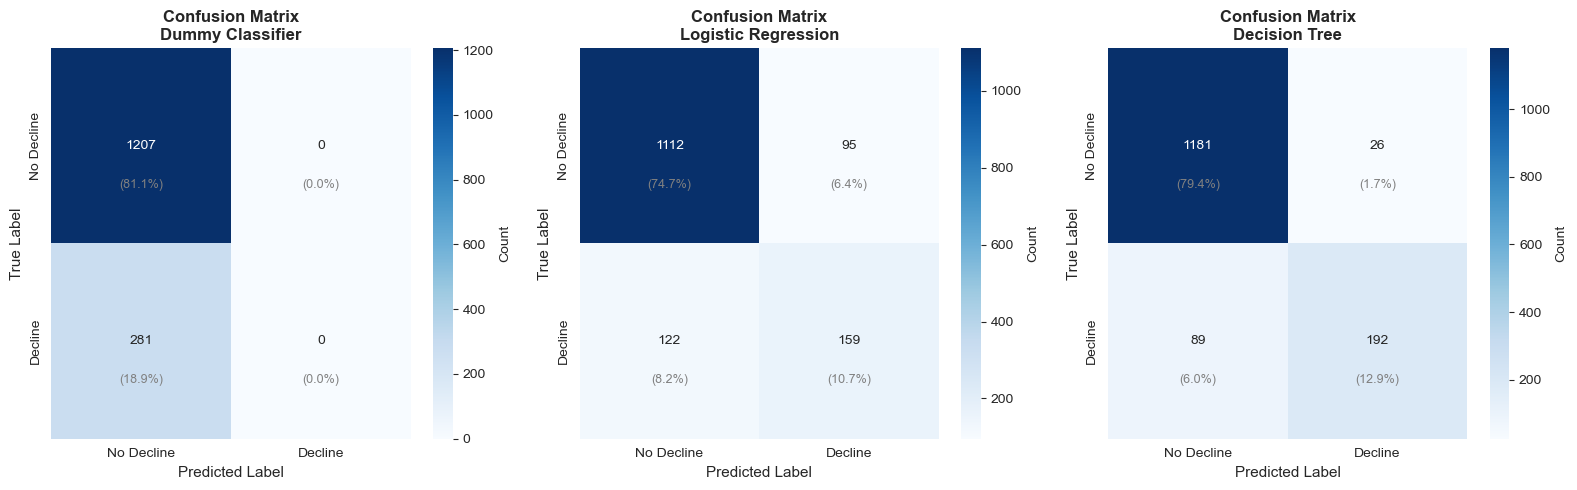

In [ ]:
# Confusion Matrices Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Helper function to plot confusion matrix
def plot_cm(cm, ax, title, model_name):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, # fmt = 'd' shows 1207 instead of 1207.0; ax tells which grid to draw on
                xticklabels=['No Decline', 'Decline'],
                yticklabels=['No Decline', 'Decline'],
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{title}\n{model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    
    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = cm[i, j] / total * 100
            ax.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', # placing the percentage below the number
                   ha='center', va='center', fontsize=9, color='gray')

plot_cm(cm_dummy, axes[0], 'Confusion Matrix', 'Dummy Classifier')
plot_cm(cm_logreg, axes[1], 'Confusion Matrix', 'Logistic Regression')
plot_cm(cm_tree, axes[2], 'Confusion Matrix', 'Decision Tree')

plt.tight_layout()
plt.show()

## Summary of Model Comparision

In [137]:
# Determine best model
best_idx = results_df['F1-Score'].idxmax()
best_model = results_df.loc[best_idx, 'Model']
best_f1 = results_df.loc[best_idx, 'F1-Score']
best_auc = results_df.loc[best_idx, 'ROC-AUC']

print(f"\nBest baseline model: {best_model}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   ROC-AUC: {best_auc:.4f}")


Best baseline model: Decision Tree
   F1-Score: 0.7695
   ROC-AUC: 0.9345
